# Module 5 Project - Modeling Final

In this notebook:

1. Create a dictionary of datasets (using each dataset version from EDA and Modeling Notebook)
2. Perform a train test split once with 15% of data reserved for validation.
3. Fit models to every dataset in a loop using gridsearch and crossvalidation on training data.
4. Store models and model stats in results - a list of dictionaries. 
5. Apply models to reserved test data and store in results.
6. Choose best model(s) and perform cross validation on total dataset (both train and test data included)

DATASETS:
1. All Features
2. Only Audio Video Columns
3. Only Audio Video Columns with collinear columns dropped.
4. Non-collinear Audio Video features, PCA on text-area fields, highest ranked bag-of-words features.
5. Non-collinear Audio Video features and highest ranked text-area features included.
6. All Audio Video Columns and highest ranked text-area and bag-of-words features.



Results Dictionary keys:
- Dataset
- model_type
- model
- model_params
- accuracy_train
- accuracy_test
- precision_train
- precision_test
- top_features

# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk")

#Sklearn Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.decomposition import PCA

#XGBoost
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import xgboost as xgb

#MY FUNCTIONS
from cf_matrix import make_confusion_matrix

import pickle #For saving cleaned dataframe to use later
import time

In [2]:
#Read in cleaned dataset from pickle file here
with open("df.pickle","rb") as f:
    df = pickle.load(f)
    
text_area_cols = df.columns[17:45]
bag_of_words_columns = df.columns[45:156]

In [172]:
#READ IN SAVED RESULTS
#with open("model_results.pickle","rb") as f_read:
#    results2 = pickle.load(f_read)

In [3]:
X = df.drop(columns=['target'])
y = df.target

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X),columns=X.columns,index=X.index)

# Train Test Split

In [87]:
random_state = np.random.randint(0,100)
random_state

79

In [88]:
#This will be used to test the cross-validated models
X_train, X_test, y_train, y_test = train_test_split(X_scaled,
                                                    y,
                                                    test_size=0.15,
                                                    random_state=random_state)

# DATASETS

The code blocks below create the 5 flavors of the dataset which will all be fit with various models for comparison purposes.

In [4]:
datasets = {}

## 1

All Data

In [89]:
datasets['1'] = (X_train,X_test,y_train,y_test) 

## 2

Audio Visual Signal Data Only

In [90]:
av_cols = list(X_train.columns[0:17])
av_cols.extend(['4124','4125'])
datasets['2'] = (X_train[av_cols],X_test[av_cols],y_train,y_test)

## 3

Only Audio Visual Columns with collinear columns dropped.

In [91]:
#FROM EDA - dropping collinear columns
#Keep 4, drop 2,3,5
#Keep 15, drop 7,14
#Keep 11, drop 10,12,13,17,1
#Keep 8, drop 9, 16
#Drop 4124, 4125 because they are not useful
av_cols = ['4','6','8','11','15']
datasets['3'] = (X_train[av_cols],X_test[av_cols],y_train,y_test)

## 4

Add in Text area and Bag of words bins - PCA on the text area bins

In [92]:
av_cols = ['4','6','8','11','15']
text_area_cols

Index(['92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102',
       '103', '104', '105', '106', '107', '108', '109', '110', '111', '112',
       '113', '114', '115', '116', '117', '118', '119'],
      dtype='object')

In [93]:
#See what the explained variance is for each feature included
pca = PCA()
pca.fit(X_train[text_area_cols])
pca.explained_variance_ratio_.cumsum()

array([0.38928447, 0.54785543, 0.62646806, 0.68970938, 0.73906004,
       0.77953484, 0.81078409, 0.84070216, 0.8623622 , 0.88310981,
       0.89940181, 0.91505952, 0.92769959, 0.93876758, 0.94777184,
       0.95545414, 0.96272375, 0.96914945, 0.97491674, 0.97992214,
       0.98395057, 0.98767086, 0.99112717, 0.99389809, 0.99594076,
       0.99758356, 0.99888009, 1.        ])

In [94]:
# Run the PCA algorithm
n = 5
pca_text_area = PCA(n_components=n)
new_column_names_text_area = [f"PC{n}_text_area" for n in range(1,n+1)]

#FIT TRANSFORM to TRAINING DATA
text_area_transformed = pca_text_area.fit_transform(X_train[text_area_cols])
text_area_transformed = pd.DataFrame(text_area_transformed, 
                                     columns=new_column_names_text_area, 
                                     index=X_train.index)
X_train_PCAed = pd.concat([X_train[av_cols],text_area_transformed], axis=1)

#APPLY FITTED TRANSFORM to TEST DATA
text_area_transformed_test = pca_text_area.transform(X_test[text_area_cols])
text_area_transformed_test = pd.DataFrame(text_area_transformed_test,
                                     columns=new_column_names_text_area,
                                     index=X_test.index)

X_test_PCAed = pd.concat([X_test[av_cols],text_area_transformed_test], axis=1)

In [95]:
datasets['4'] = (X_train_PCAed,X_test_PCAed,y_train,y_test)

## 5

Non-collinear raw Audio Video columns + most important text area columns. NO PCA columns.

In [118]:
text_area_cols_to_keep = ['92','99','100','102','104','118']
#text_area_cols_to_keep = ['92','99','102','104','118']
bag_of_words_cols_to_keep = ['129','142','156','168','924','959']
#av_cols = ['4','6','8','11','15']
av_cols = ['4','6','8','11','15']

#Originally contained bag of words columns but model performed well without
#cols = av_cols + text_area_cols_to_keep + bag_of_words_cols_to_keep
cols = av_cols + text_area_cols_to_keep

datasets['5'] = (X_train[cols],X_test[cols],y_train,y_test)

## 6

All raw Audio Video columns + most important text area and bag of words features. NO PCA columns.

In [97]:
av_cols = list(X_train.columns[0:17])
text_area_cols_to_keep = ['92','99','100','102','104','118']
bag_of_words_cols_to_keep = ['129','142','156','168','924','959']

cols = av_cols + text_area_cols_to_keep + bag_of_words_cols_to_keep

datasets['6'] = (X_train[cols],X_test[cols],y_train,y_test)

# MODELING FUNCTIONS

### Modeling Functions used to fit and then return a dictionary of stats

In [16]:
def fit_model(clf,
              train_test_data,
              param_grid,
              scoring='precision',
              cv=5,
              feature_importances=10):
    """
    This function will use a gridsearch to fit a model using the classifier and parameter
    grid provided. It will return a dictionary containng the model along with test results.
    
    INPUTS:
    clf                 = The classifier being fit.
    train_test_data     = Tuple containing train and test data in the format (X_train,X_test,y_train,y_test)
    param_grid          = The parameters to use for gridsearch fitting of the classifier.
    scoring             = The scoring method to be used by gridsearch.
    cv                  = The number of cross validations.
    feature_importances = The number of top features to include in the result.
    
    RETURNS:
    Dictionary object with the following keys:
    model           = The best model from gridsearch.
    model_params    = The best model parameters used.
    accuracy_train  = The accuracy of the model on the training data.
    accuracy_test   = The accuracy of the model on the test data.
    precision_train = The precision of the model on the training data.
    precision_test  = The precision of the model on the test data.
    top_features    = The top features by feature importance. 'None' if model does not support this behavior.
    """
    result = {}
    (X_train,X_test,y_train,y_test) = train_test_data
    
    grid_clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv, scoring=scoring)
    grid_clf.fit(X_train,y_train)
    
    result['model'] = grid_clf.best_estimator_
    result['model_params'] = grid_clf.best_params_
    
    y_pred_train = grid_clf.predict(X_train)
    y_pred_test  = grid_clf.predict(X_test)
    
    result['accuracy_train']  = round(accuracy_score(y_train,y_pred_train),4)
    result['accuracy_test']   = round(accuracy_score(y_test,y_pred_test),4)
    result['precision_train'] = round(precision_score(y_train,y_pred_train),4)
    result['precision_test']  = round(precision_score(y_test,y_pred_test),4)
    
    try:
        importances = grid_clf.best_estimator_.feature_importances_
        indices = np.argsort(importances)[::-1]
        if len(importances) < feature_importances:
            feature_importances = len(importances)    
        features = [ X_train.columns[f_idx] for f_idx in indices[0:feature_importances] ]
        result['top_features'] = features
    except:
        result['top_features'] = 'None'
    
    return result

In [46]:
def modeling_loop_helper(dataset_key,estimator,param_grid,model_type):
    """
    Helper function written to print some information to the screen for each model fit.
    It returns the gridsearched model dictionary with two keys added - dataset and model_type.
    
    INPUTS:
    dataset_key = The key corresponding to the dataset in the global datasets object.
    estimator   = The classifier which will be passed into the fit_model function.
    param_grid  = The parameter grid which will be passed into the fit_model function.
    model_type  = A string describing the model type which will be added to the result dictionary.
    
    RETURNS:
    Dictionary object containing results from fit_model function and the following additional keys:
    dataset     = The dataset key used for the model.
    model_type  = The model type description.
    
    """
    print("  ",model_type)
    start = time.time()
    result = fit_model(estimator, datasets[dataset_key], param_grid, feature_importances=20)
    result['dataset'] = dataset_key
    result['model_type'] = model_type
    end = time.time()
    print("       Accuracy: Train={}    Precision: Train={}".format(result['accuracy_train'],result['precision_train']))
    print("                 Test ={}               Test ={}".format(result['accuracy_test'],result['precision_test']))
    print(f"       time = {round(end-start,3)}")
    return result

# MODELING

### Parameter grids and classifiers to be used

Random Forest

In [18]:
rf_clf = RandomForestClassifier(max_features='auto')
param_grid_rf = [{'criterion': ['entropy'],
                  'max_depth': [5,6,7,8],
                  'n_estimators': [50,100] }]
#Tested with criterion = 'gini' also but it was never chosen

XGBoost

In [19]:
xgb_clf = xgb.XGBClassifier()
param_grid_xgb = [{'max_depth': [3,4],
                   'n_estimators': [50, 100],
                   'learning_rate': [0.1, 0.2],
                   'gamma': [0, 1] }]

Support Vector

In [20]:
svc_clf = SVC()
param_grid_svc = [{'C': [1, 10],
                   'gamma': ['auto'] }]

### Modeling Every Dataset and Store Results

In [21]:
#IN CASE I WANT TO START OVER WITH A NEW SET OF RESULTS
#results = []

In [29]:
for key in datasets.keys():
    print(f"MODELING DATASET {key}")
    
    results.append(modeling_loop_helper(key,rf_clf,param_grid_rf,"RANDOM FOREST"))
    results.append(modeling_loop_helper(key,xgb_clf,param_grid_xgb,"XGBOOST"))
    results.append(modeling_loop_helper(key,svc_clf,param_grid_svc,"SUPPORT VECTOR"))

    print("")

MODELING DATASET 1
   RANDOM FOREST
       Accuracy: Train=0.8412    Precision: Train=0.8326
                 Test =0.8386               Test =0.8207
       time = 31.415
   XGBOOST
       Accuracy: Train=0.9287    Precision: Train=0.9284
                 Test =0.9141               Test =0.9097
       time = 146.244
   SUPPORT VECTOR
       Accuracy: Train=0.9348    Precision: Train=0.9332
                 Test =0.9049               Test =0.8985
       time = 907.641

MODELING DATASET 2
   RANDOM FOREST
       Accuracy: Train=0.7949    Precision: Train=0.793
                 Test =0.7913               Test =0.7811
       time = 25.459
   XGBOOST
       Accuracy: Train=0.8576    Precision: Train=0.8615
                 Test =0.8389               Test =0.8338
       time = 24.944
   SUPPORT VECTOR
       Accuracy: Train=0.8603    Precision: Train=0.8621
                 Test =0.8457               Test =0.8418
       time = 164.217

MODELING DATASET 3
   RANDOM FOREST
       Accuracy: Tra

### One-off Models
Ran code below several times with different parameter grids on specific datasets. All results appended to results list.

In [119]:
xgb_clf = xgb.XGBClassifier()
param_grid_xgb = [{'max_depth': [4],
                   'n_estimators': [100],
                   'learning_rate': [0.1],
                   'gamma': [0, 1] }]

results.append(modeling_loop_helper('5',xgb_clf,param_grid_xgb,"XGBOOST"))

   XGBOOST
       Accuracy: Train=0.8997    Precision: Train=0.9041
                 Test =0.886               Test =0.8932
       time = 29.758


In [80]:
svc_clf = SVC()
param_grid_svc = [{'C': [1.0],
                   'gamma': ['auto'] }]

results.append(modeling_loop_helper('5',svc_clf,param_grid_svc,"SUPPORT VECTOR"))

   SUPPORT VECTOR
       Accuracy: Train=0.9019    Precision: Train=0.9038
                 Test =0.8864               Test =0.8799
       time = 84.85


In [32]:
rf_clf = RandomForestClassifier(max_features='auto')
param_grid_rf = [{'criterion': ['entropy'],
                  'max_depth': [6,7,8],
                  'min_samples_leaf': [1],
                  'n_estimators':[50,100] }]

results.append(modeling_loop_helper('5',rf_clf,param_grid_rf,"RANDOM FOREST"))

   RANDOM FOREST
       Accuracy: Train=0.8949    Precision: Train=0.8946
                 Test =0.874               Test =0.8701
       time = 128.396


## Results List

Inpect / Slide result data as needed

In [120]:
result_df = pd.DataFrame(results)

In [166]:
#result_df[(result_df.dataset=="5") & (result_df.model_type=="SUPPORT VECTOR")]
result_df[(result_df.dataset=="5") ]

,accuracy_test,accuracy_train,dataset,model,model_params,model_type,precision_test,precision_train,top_features
12,0.8326,0.8393,5,"(DecisionTreeClassifier(class_weight=None, cri...","{'criterion': 'entropy', 'max_depth': 4, 'n_es...",RANDOM FOREST,0.8327,0.8386,"[156, 924, 7, 99, 129, 959, 142, 15, 104, 100]"
13,0.8830,0.9027,5,"XGBClassifier(base_score=0.5, booster='gbtree'...",{'max_depth': 4},XGBOOST,0.8924,0.9063,"[104, 92, 118, 99, 4, 102, 8, 15, 100, 7]"
14,0.8882,0.9066,5,"SVC(C=1.0, cache_size=200, class_weight=None, ...",{'gamma': 'auto'},SUPPORT VECTOR,0.8967,0.9072,None
18,0.8755,0.8889,5,"XGBClassifier(base_score=0.5, booster='gbtree'...","{'gamma': 0, 'learning_rate': 0.1, 'max_depth'...",XGBOOST,0.8828,0.8946,"[104, 99, 92, 118, 4, 102, 8, 7, 959, 100]"
19,0.8882,0.9066,5,"SVC(C=1.0, cache_size=200, class_weight=None, ...","{'C': 1.0, 'gamma': 'auto'}",SUPPORT VECTOR,0.8967,0.9072,None
20,0.8732,0.8941,5,"(DecisionTreeClassifier(class_weight=None, cri...","{'criterion': 'entropy', 'max_depth': 8, 'min_...",RANDOM FOREST,0.8792,0.8930,"[924, 7, 99, 156, 142, 15, 104, 129, 100, 959]"
33,0.8311,0.8343,5,"(DecisionTreeClassifier(class_weight=None, cri...","{'criterion': 'entropy', 'max_depth': 4, 'n_es...",RANDOM FOREST,0.8227,0.8368,"[924, 156, 7, 15, 142, 99, 129, 959, 104, 100]"
34,0.8879,0.9031,5,"XGBClassifier(base_score=0.5, booster='gbtree'...",{'max_depth': 4},XGBOOST,0.8858,0.9076,"[104, 118, 92, 99, 102, 4, 100, 8, 15, 7]"
35,0.8884,0.9077,5,"SVC(C=1.0, cache_size=200, class_weight=None, ...",{'gamma': 'auto'},SUPPORT VECTOR,0.8845,0.9089,None
39,0.8817,0.8911,5,"XGBClassifier(base_score=0.5, booster='gbtree'...","{'gamma': 0, 'learning_rate': 0.1, 'max_depth'...",XGBOOST,0.8800,0.8958,"[104, 92, 118, 99, 4, 102, 8, 959, 100, 15]"


In [169]:
for row in result_df[(result_df.dataset=="5") & (result_df.model_type=="RANDOM FOREST")]["model_params"]:
    print(row)

{'criterion': 'entropy', 'max_depth': 4, 'n_estimators': 100}
{'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 1, 'n_estimators': 100}
{'criterion': 'entropy', 'max_depth': 4, 'n_estimators': 100}
{'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 1, 'n_estimators': 100}


In [171]:
#SAVE RESULTS TO PICKLE FILE
#with open("model_results.pickle","wb") as f_write:
#    pickle.dump(results,f_write,pickle.HIGHEST_PROTOCOL)

### KFold Cross Validation

In [125]:
def cross_val(model):
    scorer = make_scorer(precision_score)
    kfold = KFold(n_splits=10)
    cross_val_results = cross_val_score(estimator=model,
                                    X=X_scaled,
                                    y=y,
                                    cv=kfold,
                                    scoring=scorer)
    return cross_val_results

In [160]:
results[56]

{'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=1, gamma=1, learning_rate=0.1, max_delta_step=0,
        max_depth=4, min_child_weight=1, missing=None, n_estimators=100,
        n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
        silent=True, subsample=1),
 'model_params': {'gamma': 1,
  'learning_rate': 0.1,
  'max_depth': 4,
  'n_estimators': 100},
 'accuracy_train': 0.8997,
 'accuracy_test': 0.886,
 'precision_train': 0.9041,
 'precision_test': 0.8932,
 'top_features': ['104',
  '92',
  '6',
  '118',
  '99',
  '15',
  '102',
  '4',
  '11',
  '8',
  '100'],
 'dataset': '5',
 'model_type': 'XGBOOST'}

In [126]:
final_model = results[56]['model']

In [179]:
cross_val_results = cross_val(final_model)
np.mean(cross_val_results)

0.8850648070650738

### Confusion Matrix

In [151]:
final_cols = ['4', '6', '8', '11', '15', '92', '99', '100', '102', '104', '118']

In [152]:
y_pred = final_model.predict(X_scaled[final_cols])
cf = confusion_matrix(y,y_pred)

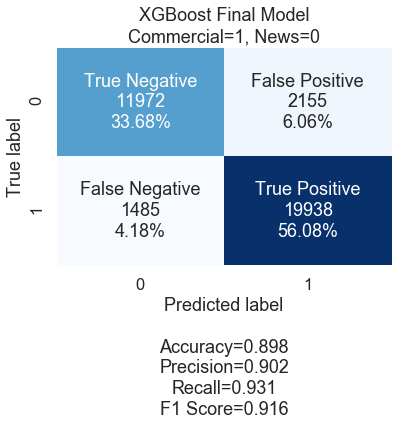

In [155]:
labels = ['True Negative','False Positive','False Negative', 'True Positive']
title = 'XGBoost Final Model\nCommercial=1, News=0'
make_confusion_matrix(cf, group_names=labels, title=title, cbar=False)

#### Original Model with all features

High dimensionality

In [162]:
model = results[1]['model']

In [164]:
y_pred = model.predict(X_scaled)
cf2 = confusion_matrix(y,y_pred)

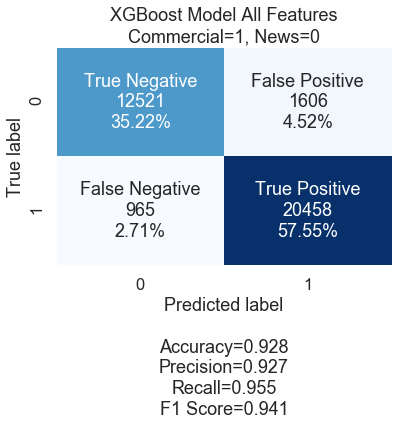

In [165]:
labels = ['True Negative','False Positive','False Negative', 'True Positive']
title = 'XGBoost Model All Features\nCommercial=1, News=0'
make_confusion_matrix(cf2, group_names=labels, title=title, cbar=False)